In [1]:
import examples.rabi_driving.setup as rabi_setup
from qsim.dynamics import Dynamics
from qsim.optimize import LeastSquaresOptimizer

import numpy as np

# boundaries of the optimization:

# The maximal driving amplitudes is restricted by the maximal rabi 
# frequency of 1Mhz
amp_bound = rabi_setup.rabi_frequency_max * 2 * np.pi / rabi_setup.lin_freq_rel

# The phase can be chosen between 0 and 100 degree
phase_bound_upper = rabi_setup.phase_max / 180 * np.pi
phase_bound_lower = 0

upper_bounds = np.concatenate(
    (amp_bound * np.ones(rabi_setup.n_time_samples),
     phase_bound_upper * np.ones(rabi_setup.n_time_samples))
)

lower_bounds = np.zeros_like(upper_bounds)

bounds_phase_control = [lower_bounds, upper_bounds]


def random_phase_control_pulse(n):
    """Creates a random control sequence. """
    amp = amp_bound * np.random.rand(n)
    phase = (phase_bound_upper - phase_bound_lower) * np.random.rand(n) 
    return np.concatenate(
        (np.expand_dims(amp, 1), np.expand_dims(phase, 1)), axis=1)


termination_conditions_phase_control = {
    "min_gradient_norm": 1e-15,
    "min_cost_gain": 1e-15,
    "max_wall_time": 30.0,
    "max_cost_func_calls": 1e6,
    "max_iterations": 100,
    "min_amplitude_change": 1e-8
}

# The dynamics class has references to the simulation code and the cost 
# functions which shall be minimized.
dynamics_phase_control = Dynamics(
    solvers=[rabi_setup.time_slot_comp_unperturbed_phase_control,
             rabi_setup.time_slot_comp_qs_noise_phase_control],
    cost_fktns=[rabi_setup.entanglement_infid_phase_control,
                rabi_setup.entanglement_infid_qs_noise_phase_control],
    cost_fktn_weights=[1, 1e2]
)

# The optimizer is essentially the least squares optimizer of the scipy
# package.
optimizer_phase_control = LeastSquaresOptimizer(
    dynamics=dynamics_phase_control,
    termination_cond=termination_conditions_phase_control, 
    save_intermediary_steps=True, 
    method='trf', 
    bounds=bounds_phase_control, 
    use_jacobian_function=True
)


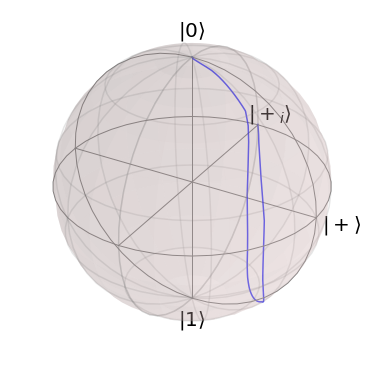

In [6]:
# we use and arbitrary pulse as starting point for the optimization.
np.random.seed(1)
initial_pulse = random_phase_control_pulse(rabi_setup.n_time_samples)

# Then we run the numerical optimization
result = (optimizer_phase_control.run_optimization(
    initial_control_amplitudes=initial_pulse))

# And plot the resulting dynamics on the bloch sphere
dynamics_phase_control.tslot_comps[0].plot_bloch_sphere()


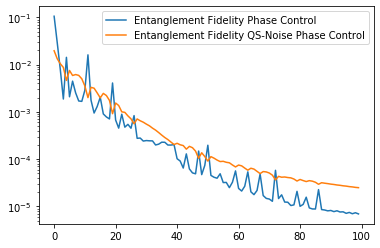

In [3]:
from qsim.data_container import DataContainer
from qsim.analyser import Analyser

# The data container can be used to store the optimization results.
storage_path = r"C:\teske\SimulationData\RabiDriving\PhaseControl"
file_name = r"test_run_1"

data_container = DataContainer(storage_path=storage_path, file_name=file_name)
data_container.append_optim_result(result)

# The Analyser class can be used visualize the optimization.
# Here we plot the cost functions in each time step.
analyser = Analyser(data_container=data_container)
analyser.plot_costs()

In [4]:
# the result class saves the relevant results of the optimization
result.to_dict()

{'final_cost': array([6.91075997e-06, 2.48568019e-05]),
 'indices': ['Entanglement Fidelity Phase Control',
  'Entanglement Fidelity QS-Noise Phase Control'],
 'final_amps': array([[0.59743411, 1.49029587],
        [0.93699146, 1.01977303],
        [1.21187492, 0.86689611],
        [1.32116086, 1.06837148],
        [1.38071642, 0.38499177],
        [1.58807302, 0.49614397],
        [1.17206761, 0.3809537 ],
        [1.39910701, 1.28478591],
        [1.01943709, 1.44928647],
        [0.43898568, 1.58743252]]),
 'final_grad_norm': 1.3537767360981724e-08,
 'init_parameters': None,
 'num_iter': 100,
 'termination_reason': 'The maximum number of function evaluations is exceeded.',
 'optimizer': <qutip.control_2.optimize.LeastSquaresOptimizer at 0x24c0e807898>,
 'optimization_stats': <qutip.control_2.stats.Stats at 0x24c090fe630>,
 'optim_iter_summary': <qutip.control_2.optimization_data.OptimIterSummary at 0x24c08fd8ba8>}

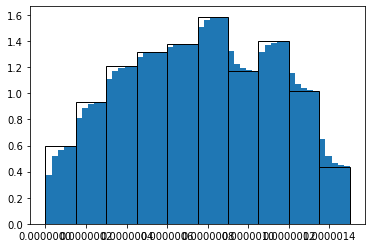

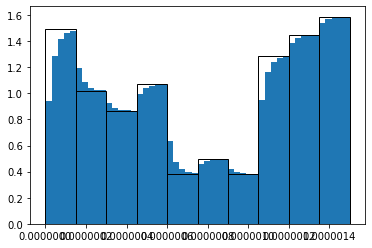

In [5]:
# Plot of the final control pulse

# The black transparent bars depict the implemented ideal pulse,
# while the blue solid bars show the pulses perceived by the qubit.

# The physical pulses have been calculated by the transfer function 
# which models an exponential saturation in the control electronics.
dynamics_phase_control.tslot_comps[0].transfer_function.plot_pulse(result.final_parameteres)
